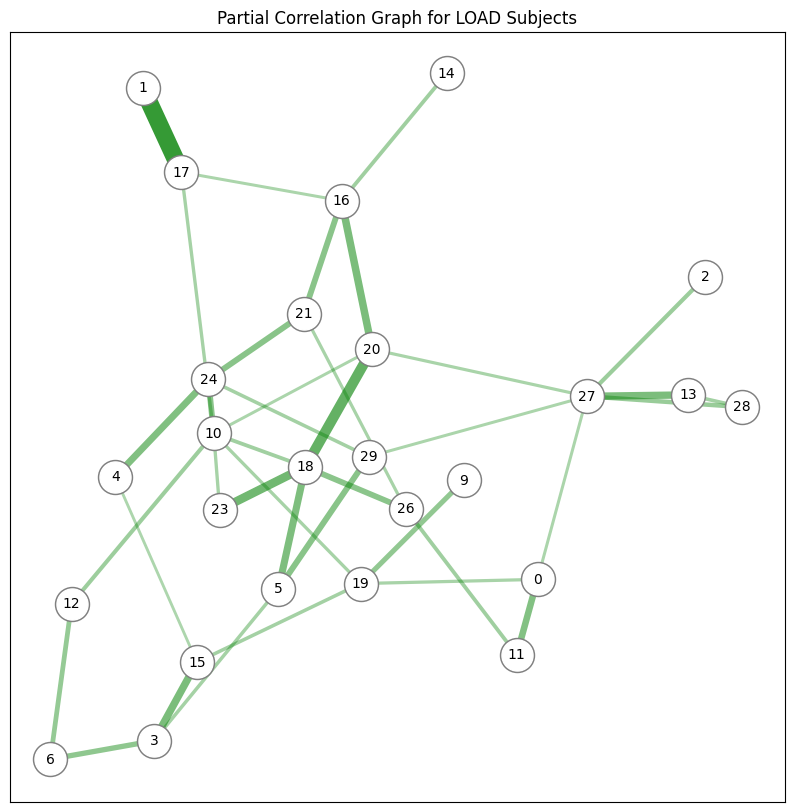

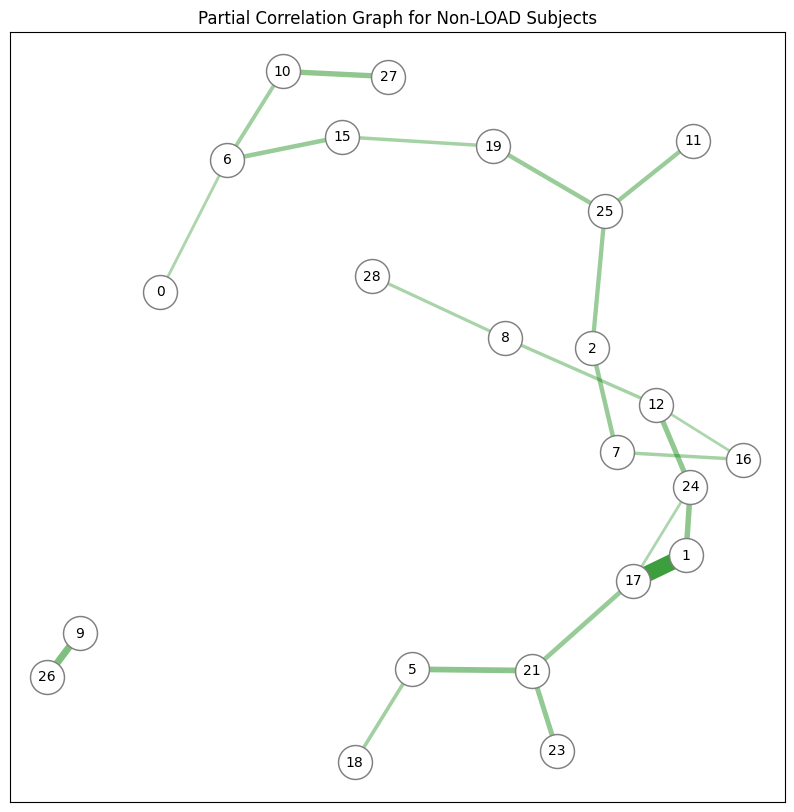

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import numpy as np
import pandas as pd
from sklearn.covariance import GraphicalLasso
import matplotlib.pyplot as plt
import networkx as nx

# Load data
sample_info = pd.read_csv('data/brain_sample_descriptions_PFC.csv')
gene_data = pd.read_csv('data/braindat.csv', index_col=0).T

# Merge datasets on common identifier
data = sample_info.merge(gene_data, left_on='!Sample_geo_accession', right_index=True, how='inner')
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['Disease'] = data['Disease'].map({'A': 1, 'N': 0})

# Extract features and target variable
X = data.drop(columns=['Disease', '!Sample_title', '!Sample_geo_accession', 'Age', 'Sex'])

# Get only the 30 most important probes
most_imp = [
    10025929611, 10023814349, 10025918353, 10023828793, 10023833276, 10023827871,
    10023824734, 10025932435, 10025927197, 10025926848, 10023839230, 10025923022,
    10025908601, 10025928439, 10025919551, 10025903058, 10025912500, 10025904476,
    10023809844, 10025910723, 10023836075, 10033668936, 10023842801, 10025908435,
    10023823964, 10033668724, 10025904331, 10025909739, 10023822775, 10025910280
]

X = X[most_imp]

X.columns = X.columns.astype(str)  # Ensure all feature names are strings
y = data['Disease']  # Assuming binary target variable

# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame for easier manipulation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=data.index)

# Split the standardized data into LOAD (Disease = 1) and non-LOAD (Disease = 0) groups
load_data = X_scaled_df[data['Disease'] == 1]
non_load_data = X_scaled_df[data['Disease'] == 0]

# Apply graphical lasso
model_load = GraphicalLasso(alpha=0.1).fit(load_data)
model_non_load = GraphicalLasso(alpha=0.1).fit(non_load_data)

# Extract precision matrices (inverse covariance)
precision_load = model_load.precision_
precision_non_load = model_non_load.precision_

# Function to create graph based on partial correlations
def create_partial_correlation_graph(precision_matrix, threshold=0.1):
    n = precision_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            partial_corr = -precision_matrix[i, j] / np.sqrt(precision_matrix[i, i] * precision_matrix[j, j])
            if abs(partial_corr) > threshold:
                G.add_edge(i, j, weight=abs(partial_corr))
    return G

# Create graphs for both groups
G_load = create_partial_correlation_graph(precision_load)
G_non_load = create_partial_correlation_graph(precision_non_load)

# Plotting function
def plot_graph(G, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    weights = nx.get_edge_attributes(G, 'weight').values()

    # Draw edges with alpha based on weights
    for (u, v, w) in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], alpha=np.sqrt(w), width=w*20, edge_color='green')

    # Draw node outline
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='grey')  # Outline layer
    # Draw nodes on top of the outline
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='white')  # Main nodes

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.show()

# Plot graphs for LOAD and non-LOAD groups
plot_graph(G_load, "Partial Correlation Graph for LOAD Subjects")
plot_graph(G_non_load, "Partial Correlation Graph for Non-LOAD Subjects")

In [21]:
node_feature_map = pd.DataFrame({
    "Node Number": range(len(X.columns)),
    "Feature Name": X.columns
})

# Display the table
print(node_feature_map)

    Node Number Feature Name
0             0  10025929611
1             1  10023814349
2             2  10025918353
3             3  10023828793
4             4  10023833276
5             5  10023827871
6             6  10023824734
7             7  10025932435
8             8  10025927197
9             9  10025926848
10           10  10023839230
11           11  10025923022
12           12  10025908601
13           13  10025928439
14           14  10025919551
15           15  10025903058
16           16  10025912500
17           17  10025904476
18           18  10023809844
19           19  10025910723
20           20  10023836075
21           21  10033668936
22           22  10023842801
23           23  10025908435
24           24  10023823964
25           25  10033668724
26           26  10025904331
27           27  10025909739
28           28  10023822775
29           29  10025910280


In [23]:
# Convert the table to LaTeX format
latex_code = node_feature_map.to_latex(index=False)
print(latex_code)

\begin{tabular}{rl}
\toprule
Node Number & Feature Name \\
\midrule
0 & 10025929611 \\
1 & 10023814349 \\
2 & 10025918353 \\
3 & 10023828793 \\
4 & 10023833276 \\
5 & 10023827871 \\
6 & 10023824734 \\
7 & 10025932435 \\
8 & 10025927197 \\
9 & 10025926848 \\
10 & 10023839230 \\
11 & 10025923022 \\
12 & 10025908601 \\
13 & 10025928439 \\
14 & 10025919551 \\
15 & 10025903058 \\
16 & 10025912500 \\
17 & 10025904476 \\
18 & 10023809844 \\
19 & 10025910723 \\
20 & 10023836075 \\
21 & 10033668936 \\
22 & 10023842801 \\
23 & 10025908435 \\
24 & 10023823964 \\
25 & 10033668724 \\
26 & 10025904331 \\
27 & 10025909739 \\
28 & 10023822775 \\
29 & 10025910280 \\
\bottomrule
\end{tabular}

